# Convert and Optimize YOLOv10 with OpenVINO

Real-time object detection aims to accurately predict object categories and positions in images with low latency. The YOLO series has been at the forefront of this research due to its balance between performance and efficiency. However, reliance on NMS and architectural inefficiencies have hindered optimal performance. YOLOv10 addresses these issues by introducing consistent dual assignments for NMS-free training and a holistic efficiency-accuracy driven model design strategy.

YOLOv10, built on the [Ultralytics Python package](https://pypi.org/project/ultralytics/) by researchers at [Tsinghua University](https://www.tsinghua.edu.cn/en/), introduces a new approach to real-time object detection, addressing both the post-processing and model architecture deficiencies found in previous YOLO versions. By eliminating non-maximum suppression (NMS) and optimizing various model components, YOLOv10 achieves state-of-the-art performance with significantly reduced computational overhead. Extensive experiments demonstrate its superior accuracy-latency trade-offs across multiple model scales.

![yolov10-approach.png](https://github.com/ultralytics/ultralytics/assets/26833433/f9b1bec0-928e-41ce-a205-e12db3c4929a)

More details about model architecture you can find in original [repo](https://github.com/THU-MIG/yolov10), [paper](https://arxiv.org/abs/2405.14458) and [Ultralytics documentation](https://docs.ultralytics.com/models/yolov10/).

This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLO V10 with OpenVINO.

The tutorial consists of the following steps:

- Prepare PyTorch model
- Convert PyTorch model to OpenVINO IR
- Run model inference with OpenVINO
- Prepare and run optimization pipeline using NNCF
- Compare performance of the FP16 and quantized models.
- Run optimized model inference on video
- Launch interactive Gradio demo

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Download PyTorch model](#Download-PyTorch-model)
- [Export PyTorch model to OpenVINO IR Format](#Export-PyTorch-model-to-OpenVINO-IR-Format)
- [Run OpenVINO Inference on AUTO device using Ultralytics API](#Run-OpenVINO-Inference-on-AUTO-device-using-Ultralytics-API)
- [Run OpenVINO Inference on selected device using Ultralytics API](#Run-OpenVINO-Inference-on-selected-device-using-Ultralytics-API)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API)
    - [Prepare Quantization Dataset](#Prepare-Quantization-Dataset)
    - [Quantize and Save INT8 model](#Quantize-and-Save-INT8-model)
- [Run Optimized Model Inference](#Run-Optimized-Model-Inference)
    - [Run Optimized Model on AUTO device](#Run-Optimized-Model-on-AUTO-device)
    - [Run Optimized Model Inference on selected device](#Run-Optimized-Model-Inference-on-selected-device)
- [Compare the Original and Quantized Models](#Compare-the-Original-and-Quantized-Models)
    - [Model size](#Model-size)
    - [Performance](#Performance)
    - [FP16 model performance](#FP16-model-performance)
    - [Int8 model performance](#Int8-model-performance)
- [Live demo](#Live-demo)
    - [Gradio Interactive Demo](#Gradio-Interactive-Demo)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import os

os.environ["GIT_CLONE_PROTECTION_ACTIVE"] = "false"

%pip uninstall -y -q openvino openvino-dev openvino-nightly
%pip install -q "openvino-nightly" "git+https://github.com/openvinotoolkit/nncf.git"
%pip install -q git+https://github.com/THU-MIG/yolov10.git --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "torch>=2.1" "torchvision>=0.16" tqdm opencv-python "gradio>=4.19" --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer

## Download PyTorch model
[back to top ⬆️](#Table-of-contents:)


There are several version of [YOLO V10](https://github.com/THU-MIG/yolov10/tree/main?tab=readme-ov-file#performance) models provided by model authors. Each of them has different characteristics depends on number of training parameters, performance and accuracy. For demonstration purposes we will use `yolov10n`, but the same steps are also applicable to other models in YOLO V10 series.

In [3]:
models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)

In [4]:
model_weights_url = "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt"
file_name = model_weights_url.split("/")[-1]
model_name = file_name.replace(".pt", "")

download_file(model_weights_url, directory=models_dir)

'models/yolov10n.pt' already exists.


PosixPath('/home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/yolov10-optimization/models/yolov10n.pt')

## Export PyTorch model to OpenVINO IR Format
[back to top ⬆️](#Table-of-contents:)

As it was discussed before, YOLO V10 code is designed on top of [Ultralytics](https://docs.ultralytics.com/) library and has similar interface with YOLO V8 (You can check [YOLO V8 notebooks](https://github.com/openvinotoolkit/openvino_notebooks/tree/latest/notebooks/yolov8-optimization) for more detailed instruction how to work with Ultralytics API). Ultralytics support OpenVINO model export using [export](https://docs.ultralytics.com/modes/export/) method of model class. Additionally, we can specify parameters responsible for target input size, static or dynamic input shapes and model precision (FP32/FP16/INT8). INT8 quantization can be additionally performed on export stage, but for making approach more flexible, we consider how to perform quantization using [NNCF](https://github.com/openvinotoolkit/nncf).

In [5]:
import types
from ultralytics.utils import ops
from ultralytics import YOLOv10
import torch


def v10_det_head_forward(self, x):
    one2one = self.forward_feat([xi.detach() for xi in x], self.one2one_cv2, self.one2one_cv3)
    if not self.export:
        one2many = super().forward(x)

    if not self.training:
        one2one = self.inference(one2one)
        if not self.export:
            return {"one2many": one2many, "one2one": one2one}
        else:
            assert self.max_det != -1
            boxes, scores, labels = ops.v10postprocess(one2one.permute(0, 2, 1), self.max_det, self.nc)
            return torch.cat(
                [boxes, scores.unsqueeze(-1), labels.unsqueeze(-1).to(boxes.dtype)],
                dim=-1,
            )
    else:
        return {"one2many": one2many, "one2one": one2one}


ov_model_path = models_dir / f"{model_name}_openvino_model/{model_name}.xml"
if not ov_model_path.exists():
    model = YOLOv10(models_dir / file_name)
    model.model.model[-1].forward = types.MethodType(v10_det_head_forward, model.model.model[-1])
    model.export(format="openvino", dynamic=True, half=True)

## Run OpenVINO Inference on AUTO device using Ultralytics API
[back to top ⬆️](#Table-of-contents:)


Now, when we exported model to OpenVINO, we can load it directly into YOLOv10 class, where automatic inference backend will provide easy-to-use user experience to run OpenVINO YOLOv10 model on the similar level like for original PyTorch model. The code bellow demonstrates how to run inference OpenVINO exported model with Ultralytics API on single image. [AUTO device](https://github.com/openvinotoolkit/openvino_notebooks/tree/latest/notebooks/auto-device) will be used for launching model.

In [6]:
ov_yolo_model = YOLOv10(ov_model_path.parent, task="detect")

In [7]:
from PIL import Image

IMAGE_PATH = Path("./data/coco_bike.jpg")
download_file(
    url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
    filename=IMAGE_PATH.name,
    directory=IMAGE_PATH.parent,
)

'data/coco_bike.jpg' already exists.


PosixPath('/home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/yolov10-optimization/data/coco_bike.jpg')

Loading models/yolov10n_openvino_model for OpenVINO inference...
requirements: Ultralytics requirement ['openvino>=2024.0.0'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/yolov10-optimization/data/coco_bike.jpg: 640x640 1 1, 2 2s, 1 3, 1 16, 73.6ms
Speed: 24.4ms preprocess, 73.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


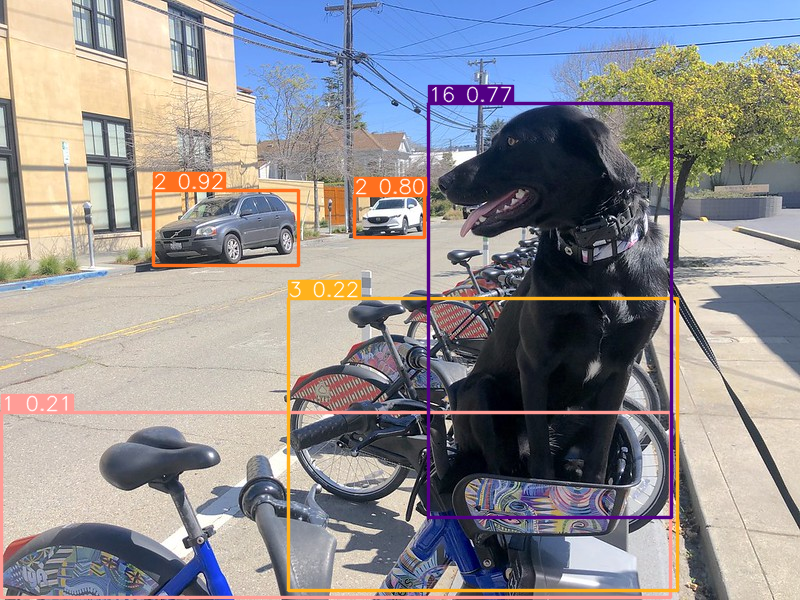

In [8]:
res = ov_yolo_model(IMAGE_PATH, iou=0.45, conf=0.2)
Image.fromarray(res[0].plot()[:, :, ::-1])

## Run OpenVINO Inference on selected device using Ultralytics API
[back to top ⬆️](#Table-of-contents:)


In this part of notebook you can select inference device for running model inference to compare results with AUTO.

In [9]:
import openvino as ov

import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='CPU')

In [10]:
ov_model = core.read_model(ov_model_path)

# load model on selected device
if "GPU" in device.value or "NPU" in device.value:
    ov_model.reshape({0: [1, 3, 640, 640]})
ov_config = {}
if "GPU" in device.value:
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
det_compiled_model = core.compile_model(ov_model, device.value, ov_config)

In [11]:
ov_yolo_model.predictor.model.ov_compiled_model = det_compiled_model


image 1/1 /home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/yolov10-optimization/data/coco_bike.jpg: 640x640 1 1, 2 2s, 1 3, 1 16, 28.0ms
Speed: 2.8ms preprocess, 28.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


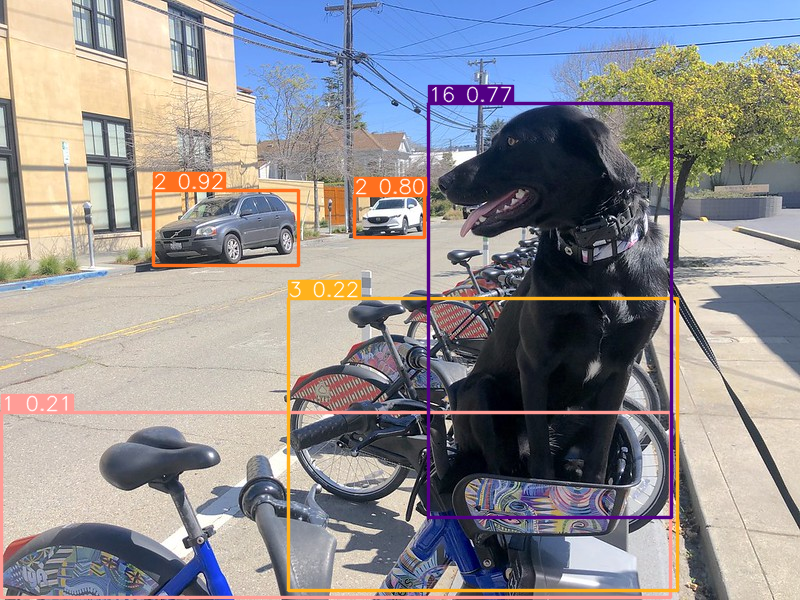

In [12]:
res = ov_yolo_model(IMAGE_PATH, iou=0.45, conf=0.2)
Image.fromarray(res[0].plot()[:, :, ::-1])

## Optimize model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)


[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv10.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize OpenVINO IR model, using the `openvino.save_model` function.

Quantization is time and memory consuming process, you can skip this step using checkbox bellow:

In [13]:
import ipywidgets as widgets

int8_model_det_path = models_dir / "int8" / f"{model_name}_openvino_model/{model_name}.xml"
ov_yolo_int8_model = None

to_quantize = widgets.Checkbox(
    value=True,
    description="Quantization",
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

In [14]:
# Fetch skip_kernel_extension module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

### Prepare Quantization Dataset
[back to top ⬆️](#Table-of-contents:)


For starting quantization, we need to prepare dataset. We will use validation subset from [MS COCO dataset](https://cocodataset.org/) for model quantization and Ultralytics validation data loader for preparing input data.

In [15]:
%%skip not $to_quantize.value

from zipfile import ZipFile

from ultralytics.data.utils import DATASETS_DIR


DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco.yaml"

OUT_DIR = DATASETS_DIR

DATA_PATH = OUT_DIR / "val2017.zip"
LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
CFG_PATH = OUT_DIR / "coco.yaml"

download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(LABELS_PATH, "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(DATA_PATH, "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / "coco/images")

'/home/ea/work/openvino_notebooks/notebooks/fast-segment-anything/datasets/val2017.zip' already exists.
'/home/ea/work/openvino_notebooks/notebooks/fast-segment-anything/datasets/coco2017labels-segments.zip' already exists.


/home/ea/work/openvino_notebooks/notebooks/fast-segment-anything/datasets/coco.yaml:   0%|          | 0.00/1.2…

In [16]:
%%skip not $to_quantize.value

from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class
from ultralytics.data.utils import check_det_dataset

args = get_cfg(cfg=DEFAULT_CFG)
args.data = str(CFG_PATH)
det_validator = ov_yolo_model.task_map[ov_yolo_model.task]["validator"](args=args)

det_validator.data = check_det_dataset(args.data)
det_validator.stride = 32
det_data_loader = det_validator.get_dataloader(OUT_DIR / "coco", 1)

val: Scanning /home/ea/work/openvino_notebooks/notebooks/fast-segment-anything/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


NNCF provides `nncf.Dataset` wrapper for using native framework dataloaders in quantization pipeline. Additionally, we specify transform function that will be responsible for preparing input data in model expected format.

In [17]:
%%skip not $to_quantize.value

import nncf
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = det_validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


### Quantize and Save INT8 model
[back to top ⬆️](#Table-of-contents:)


The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. YOLOv10 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve a better result, we will use a `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations.

>**Note**: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [18]:
%%skip not $to_quantize.value

import shutil

quantized_det_model = nncf.quantize(
    ov_model,
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
)

ov.save_model(quantized_det_model,  int8_model_det_path)
shutil.copy(ov_model_path.parent / "metadata.yaml", int8_model_det_path.parent / "metadata.yaml")

Output()

Output()

## Run Optimized Model Inference
[back to top ⬆️](#Table-of-contents:)


The way of usage INT8 quantized model is the same like for model before quantization. Let's check inference result of quantized model on single image

### Run Optimized Model on AUTO device
[back to top ⬆️](#Table-of-contents:)

In [19]:
%%skip not $to_quantize.value
ov_yolo_int8_model = YOLOv10(int8_model_det_path.parent, task="detect")

In [20]:
%%skip not $to_quantize.value
res = ov_yolo_int8_model(IMAGE_PATH, iou=0.45, conf=0.2)

Image.fromarray(res[0].plot()[:, :, ::-1])

Loading models/int8/yolov10n_openvino_model for OpenVINO inference...
requirements: Ultralytics requirement ['openvino>=2024.0.0'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/yolov10-optimization/data/coco_bike.jpg: 640x640 1 1, 3 2s, 2 3s, 1 16, 91.0ms
Speed: 2.7ms preprocess, 91.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


### Run Optimized Model Inference on selected device
[back to top ⬆️](#Table-of-contents:)

In [21]:
%%skip not $to_quantize.value

device

In [22]:
%%skip not $to_quantize.value

ov_config = {}
if "GPU" in device.value or "NPU" in device.value:
    ov_model.reshape({0: [1, 3, 640, 640]})
ov_config = {}
if "GPU" in device.value:
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
quantized_det_compiled_model = core.compile_model(quantized_det_model, device.value, ov_config)

ov_yolo_int8_model.predictor.model.ov_compiled_model = quantized_det_compiled_model

res = ov_yolo_int8_model(IMAGE_PATH)

Image.fromarray(res[0].plot()[:, :, ::-1])


image 1/1 /home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/yolov10-optimization/data/coco_bike.jpg: 640x640 2 2s, 1 16, 27.0ms
Speed: 6.8ms preprocess, 27.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


## Compare the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)

### Model size
[back to top ⬆️](#Table-of-contents:)

In [23]:
ov_model_weights = ov_model_path.with_suffix(".bin")
print(f"Size of FP16 model is {ov_model_weights.stat().st_size / 1024 / 1024:.2f} MB")
if int8_model_det_path.exists():
    ov_int8_weights = int8_model_det_path.with_suffix(".bin")
    print(f"Size of model with INT8 compressed weights is {ov_int8_weights.stat().st_size / 1024 / 1024:.2f} MB")
    print(f"Compression rate for INT8 model: {ov_model_weights.stat().st_size / ov_int8_weights.stat().st_size:.3f}")

Size of FP16 model is 4.39 MB
Size of model with INT8 compressed weights is 2.25 MB
Compression rate for INT8 model: 1.954


### Performance
[back to top ⬆️](#Table-of-contents:)


### FP16 model performance
[back to top ⬆️](#Table-of-contents:)

In [24]:
!benchmark_app -m $ov_model_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.2.0-15496-17f8e86e5f2-releases/2024/2
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2024.2.0-15496-17f8e86e5f2-releases/2024/2
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 25.06 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.23/aten::cat/Concat_8) : f32 / [...] / [?,300,6]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 

### Int8 model performance
[back to top ⬆️](#Table-of-contents:)

In [25]:
if int8_model_det_path.exists():
    !benchmark_app -m $int8_model_det_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.2.0-15496-17f8e86e5f2-releases/2024/2
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2024.2.0-15496-17f8e86e5f2-releases/2024/2
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 39.26 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.23/aten::cat/Concat_8) : f32 / [...] / [?,300,6]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 

## Live demo
[back to top ⬆️](#Table-of-contents:)


The following code runs model inference on a video:

In [26]:
import collections
import time
from IPython import display
import cv2
import numpy as np


# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    det_model=ov_yolo_int8_model,
    device=device.value,
):
    player = None
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)

            start_time = time.time()
            detections = det_model(input_image, iou=0.45, conf=0.2, verbose=False)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

In [27]:
use_int8 = widgets.Checkbox(
    value=ov_yolo_int8_model is not None,
    description="Use int8 model",
    disabled=ov_yolo_int8_model is None,
)

use_int8

Checkbox(value=True, description='Use int8 model')

In [28]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4",
        directory="data",
    )
    VIDEO_SOURCE = "data/people.mp4"

'data/people.mp4' already exists.


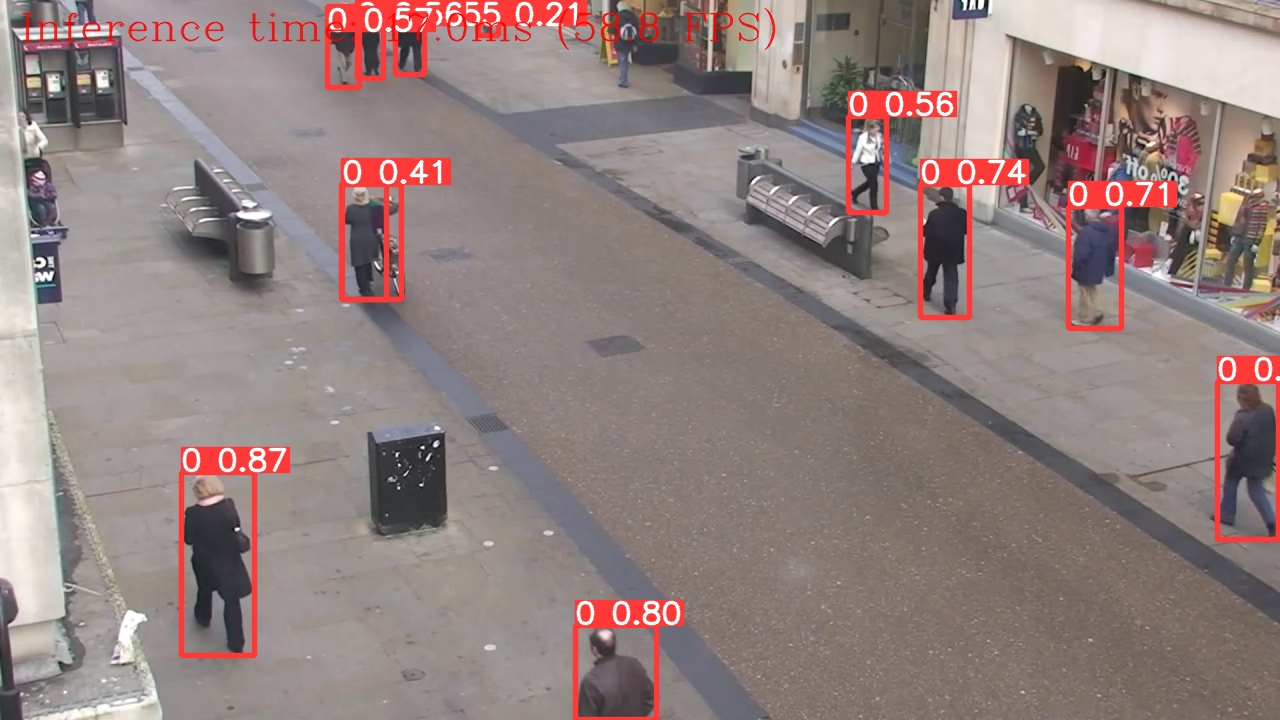

Source ended


In [29]:
run_object_detection(
    det_model=ov_yolo_model if not use_int8.value else ov_yolo_int8_model,
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
)

### Gradio Interactive Demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import gradio as gr


def yolov10_inference(image, int8, conf_threshold, iou_threshold):
    model = ov_yolo_model if not int8 else ov_yolo_int8_model
    results = model(source=image, iou=iou_threshold, conf=conf_threshold, verbose=False)[0]
    annotated_image = Image.fromarray(results.plot())

    return annotated_image


with gr.Blocks() as demo:
    gr.HTML(
        """
    <h1 style='text-align: center'>
    YOLOv10: Real-Time End-to-End Object Detection using OpenVINO
    </h1>
    """
    )
    with gr.Row():
        with gr.Column():
            image = gr.Image(type="numpy", label="Image")
            conf_threshold = gr.Slider(
                label="Confidence Threshold",
                minimum=0.1,
                maximum=1.0,
                step=0.1,
                value=0.2,
            )
            iou_threshold = gr.Slider(
                label="IoU Threshold",
                minimum=0.1,
                maximum=1.0,
                step=0.1,
                value=0.45,
            )
            use_int8 = gr.Checkbox(
                value=ov_yolo_int8_model is not None,
                visible=ov_yolo_int8_model is not None,
                label="Use INT8 model",
            )
            yolov10_infer = gr.Button(value="Detect Objects")

        with gr.Column():
            output_image = gr.Image(type="pil", label="Annotated Image")

        yolov10_infer.click(
            fn=yolov10_inference,
            inputs=[
                image,
                use_int8,
                conf_threshold,
                iou_threshold,
            ],
            outputs=[output_image],
        )


try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)